In [2]:
from numba import cuda
from keras import backend as K

from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

Using TensorFlow backend.


In [3]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df['step_value'].replace('', 0, inplace=True)
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

In [4]:
df.timestamp = df.timestamp.apply(lambda x: pd.datetime.fromtimestamp(x))

In [5]:
df.head()

,_id,day,hour,hr_value,latitude,longitude,minute,month,o2_value,second,step_value,timestamp,year,weekday,week
0,5c9b3935c4e5a668b7e9be2c,27,16,84.0,24.945194,121.372277,49,3,95.0,47,0.0,2019-03-27 16:49:47,2019,3,12
1,5c9b393fc4e5a668b7e9be2e,27,16,84.0,24.945194,121.372277,49,3,95.0,57,0.0,2019-03-27 16:49:57,2019,3,12
2,5c9b3949c4e5a668b7e9be30,27,16,84.0,24.945194,121.372277,50,3,95.0,7,0.0,2019-03-27 16:50:07,2019,3,12
3,5c9b3953c4e5a668b7e9be32,27,16,84.0,24.945194,121.372277,50,3,95.0,17,0.0,2019-03-27 16:50:17,2019,3,12
4,5c9b395dc4e5a668b7e9be34,27,16,79.0,24.945194,121.372277,50,3,98.0,27,0.0,2019-03-27 16:50:27,2019,3,12


In [6]:
dfgroup = df.groupby(pd.Grouper(key='timestamp',freq='180s'))

In [104]:
dfnew = pd.concat([dfgroup['step_value'].sum(), 
           dfgroup['hr_value'].mean()],axis=1)

In [105]:
dfnew = dfnew[(dfnew['step_value'] != 0)]

In [106]:
dfnew.describe()

,step_value,hr_value
count,3099.000000,3099.000000
mean,128.020652,81.856714
std,117.223153,20.770824
min,1.000000,48.000000
25%,37.000000,66.333333
50%,89.000000,79.333333
75%,209.000000,94.000000
max,2167.000000,179.000000


In [17]:
from scipy import stats

In [118]:
dfnew = dfnew[(np.abs(stats.zscore(dfnew)) < 5).all(axis=1)]

In [119]:
dfnew.describe()

,step_value,hr_value
count,3091.000000,3091.000000
mean,125.230670,81.836255
std,101.439249,20.758397
min,1.000000,48.000000
25%,37.000000,66.333333
50%,89.000000,79.294118
75%,208.000000,94.000000
max,700.000000,179.000000


In [120]:
X = np.array(list(zip(dfnew.hr_value, dfnew.step_value)))

In [122]:
# Number of clusters
k = 4
# X coordinates of random centroids
C_x = np.random.randint(0, np.max(X)- 300, size=k)
# Y coordinates of random centroids
C_y = np.random.randint(0, np.max(X) - 210,size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
# C_x = [-2, 6]
# C_y = [4, -6]
# C = np.array(list(zip(C_x,C_y)))
print(C)

[[321. 154.]
 [149. 270.]
 [ 39. 376.]
 [166. 468.]]


<IPython.core.display.Javascript object>


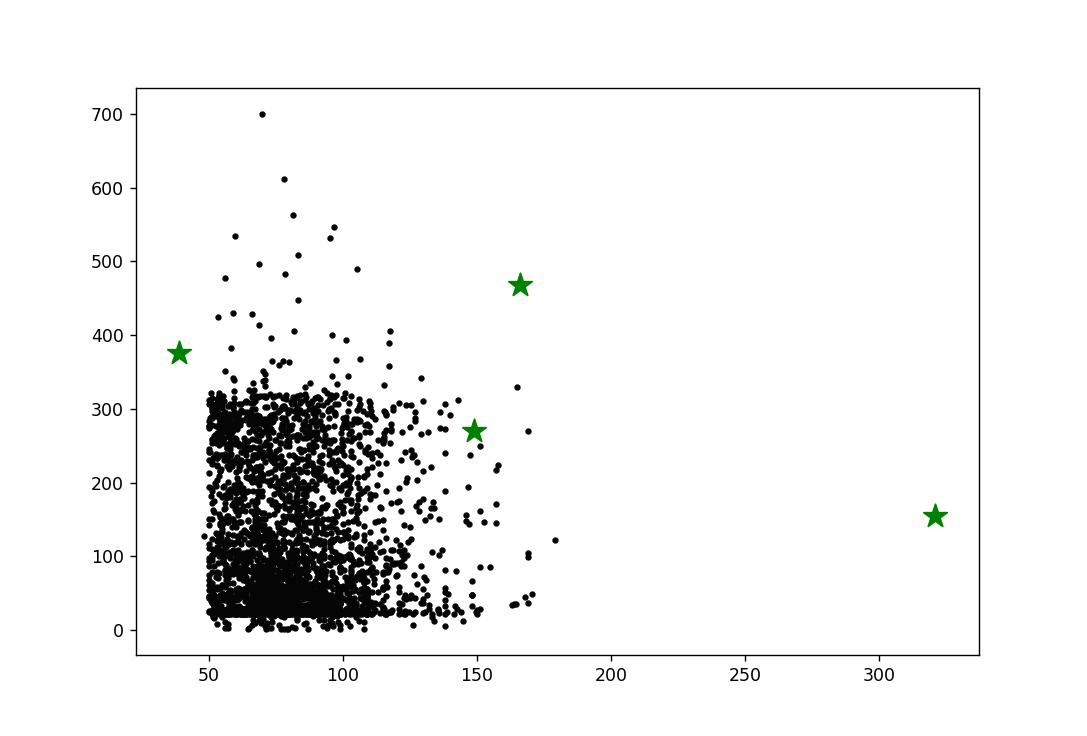

In [124]:
# Plotting along with the Centroids
%matplotlib notebook
fig = plt.figure()
plt.scatter(dfnew.hr_value, dfnew.step_value, c='#050505', s=7)
plt.scatter(C_x, C_y, marker='*', s=200, c='g')
plt.show()

In [116]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [117]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster    
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)
    clear_output(wait=True)
    print(error)

nan


KeyboardInterrupt: 

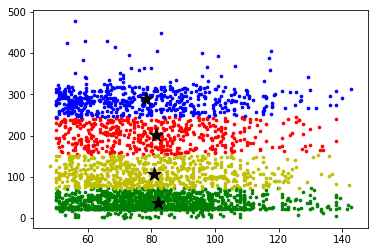

In [103]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
plt.show()

In [88]:
pd.concat([dfgroup.get_group('2019-03-27 17:00:00')['step_value'], 
           dfgroup.get_group('2019-03-27 17:00:00')['hr_value']],axis=1)

,step_value,hr_value
62,24.0,83.0
63,16.0,83.0
64,10.0,83.0
65,0.0,83.0
66,22.0,83.0
67,16.0,54.0
68,16.0,54.0
69,3.0,54.0
70,0.0,54.0
71,0.0,54.0


In [34]:
dfgroup[:1000].describe()

TypeError: unhashable type: 'slice'

In [5]:
dfadd = pd.DataFrame({})

In [9]:
flag = False
group = 0
basetime = 0
for index, rows in df.iterrows():
    if flag == False:
        basetime = rows['timestamp']
        group += 1
        rows['group'] = group
        flag = True
    else:
        if rows['timestamp'] < (basetime + 60*3):
            rows['group'] = group
        else:
            flag=False
            basetime = rows['timestamp']
            group += 1
            rows['group'] = group
            flag = True
    dfadd = dfadd.append(rows)
    break

In [5]:
df[0:1000].corr()

,day,hour,hr_value,latitude,longitude,minute,month,o2_value,second,step_value,timestamp,year,week
day,1.000000,-0.909047,0.097849,-0.067765,-0.064285,-0.038783,NaN,-0.088221,-0.014706,-0.037241,0.521621,NaN,NaN
hour,-0.909047,1.000000,0.041718,-0.187549,-0.180070,-0.054038,NaN,-0.060263,0.007272,-0.077647,-0.124628,NaN,NaN
hr_value,0.097849,0.041718,1.000000,-0.118377,-0.095960,0.092059,NaN,-0.282586,0.000434,0.093837,0.340095,NaN,NaN
latitude,-0.067765,-0.187549,-0.118377,1.000000,0.979758,0.069097,NaN,-0.019184,-0.009501,0.131152,-0.546803,NaN,NaN
longitude,-0.064285,-0.180070,-0.095960,0.979758,1.000000,0.075752,NaN,-0.011370,-0.011217,0.114890,-0.521612,NaN,NaN
minute,-0.038783,-0.054038,0.092059,0.069097,0.075752,1.000000,NaN,0.029462,0.021606,-0.015533,-0.048121,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
o2_value,-0.088221,-0.060263,-0.282586,-0.019184,-0.011370,0.029462,NaN,1.000000,0.008150,0.073010,-0.336140,NaN,NaN
second,-0.014706,0.007272,0.000434,-0.009501,-0.011217,0.021606,NaN,0.008150,1.000000,-0.007657,-0.014294,NaN,NaN
step_value,-0.037241,-0.077647,0.093837,0.131152,0.114890,-0.015533,NaN,0.073010,-0.007657,1.000000,-0.255772,NaN,NaN


In [9]:
df[]

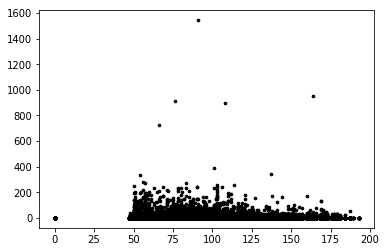

In [11]:
fig = plt.figure()
plt.scatter(df.hr_value, df.step_value, c='black', s=7)
plt.show()

In [ ]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
# collection = [db.User_Info]# db.db2, db.dn2, db.james, db.leo
# userInfo = []

collection = [db.james]
#     collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)
df = df[(df['hr_value'] != 0)]

    # map out the weekday
#     df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
#     df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
#               - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

#     dfsteptotal = pd.DataFrame({})
#     dfsteptotal = df[['week', 'weekday']].set_index(['week', 'weekday'])
#     dfsteptotal = dfsteptotal[~dfsteptotal.index.duplicated(keep='first')]
#     earlestweek = df['week'].values[0]
#     latestweek = df['week'].values[-1]
#     addindex = pd.DataFrame({})
#     for i in range(earlestweek, latestweek):
#         for j in range(7):
#             if not (i,str(j)) in dfsteptotal.index:
#                 add = pd.DataFrame({'week':[i],'weekday':[str(j)]})
#                 addindex = addindex.append(add)
#     todayweekday = int(datetime.datetime.now().strftime('%w'))
#     for j in range(int(todayweekday)):
#         if not (latestweek,str(j)) in dfsteptotal.index:
#             add = pd.DataFrame({'week':[latestweek],'weekday':[str(j)]})
#             addindex = addindex.append(add)
#     dfsteptotal.reset_index(inplace=True)
#     dfsteptotal = dfsteptotal.append(addindex)
#     dfsteptotal = dfsteptotal.set_index(['week', 'weekday'])
#     dfsteptotal = dfsteptotal.sort_index()
#     dfsteptotal['steps'] = 0

#     # here I map between integer and the sting it's mean
#     timeslidemap = {0:'morning', 1:'afternoon', 2:'evening'}
#     basestamp = df['timestamp'][0]
#     endstamp = df['timestamp'][-1:].values[0]
#     # for num, row in df[:30000].iterrows():
#     while True:
#         try:
#             dfbetween = df.loc[df['timestamp'].between(
#                 datetime.datetime.fromtimestamp(basestamp).replace(hour=0,minute=0,second=0).timestamp(),
#                 datetime.datetime.fromtimestamp(basestamp).replace(hour=23,minute=59,second=59).timestamp()
#                         , inclusive=True)]
#             steps = dfbetween['step_value'].sum()
#         #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
#         #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
#         #                 timeslidemap[estimedevide])

#             dfsteptotal.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
#                                         (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
#                                 datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
#                                                ['steps']] += steps

#             basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
#             if basestamp > endstamp:
#                 break
#         except Exception as e:
#             print(str(e))
#             basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
#     #     else:
#     #         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))


# #         dfsteptotal.loc[(12,'5')] = dfsteptotal.xs('5', level=1).sum() / (dfsteptotal.xs('5', level=1).count() - 1)
#     dfsteptotal['Comfort'] = 0
#     dfsteptotal['Precp'] = 0

#     # add wether 
#     coding = 'utf-8'
#     table = pd.DataFrame()
#     basetime = datetime.datetime.fromtimestamp(df['timestamp'][0])
#     num = 0
    
    
    
#         for index, row in dfsteptotal.iterrows():
#             try:
#                 # parsing part
#                 date = basetime + datetime.timedelta(days = num) 
#                 num += 1
#                 dateStr = date.strftime('%Y-%m-%d')
#                 url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=C0AC60'+ \
#                     '&stname=%25E4%25B8%2589%25E5%25B3%25BD&datepicker=' + dateStr
#                 table = pd.read_html(url,encoding=coding,index_col=0,header=None,flavor='bs4')[1]
#                 # start dataprocess
#                 table.replace('/', np.nan, inplace=True)
#                 table.replace('X', np.nan, inplace=True)  
#                 table.fillna(method='ffill', inplace=True)
#                 table.index -= 1
#                 dfoneday = pd.DataFrame()
#                 # the table data need to reshape and turn to a variable
#                 T = table['temperature'].values.reshape(len(table['temperature'].values)).astype('float')
#                 RH = table['RH'].values.reshape(len(table['RH'].values)).astype('float')
#                 dfoneday['comfort'] = T - 0.55 *(1-RH/100)*(T - 14)
#                 dfoneday['Precp'] = table['Precp']['降水量(mm)']
#                 bins = [0,11,16,20,27,31,60]
#                 labels=[0,1,2,3,4,5]
#                 dfoneday['bins'] = pd.cut(dfoneday['comfort'], bins=bins, labels=labels, include_lowest=True)
#                 # mComfort aComfort eComfort mPrecp aPrecp ePrecp
#                 dfsteptotal.loc[[index], ['Comfort']] = dfoneday['bins'].astype(int).mean()
#                 dfoneday['Precp'].astype(float)
#                 dfsteptotal.loc[[index], ['Precp']] = dfoneday['Precp'].astype(float).sum()
#             except Exception as e:
#                 if str(e) == "could not convert string to float: '...'":
#                     print('some data are not yet ready')
#                     break
        # same day as today
#         print(date)

#         steps = dfsteptotal['steps'][:-1].values
#         Comfort = dfsteptotal['Comfort'][:-1].values
#         Precp = dfsteptotal['Precp'][:-1].values

#         scaler = preprocessing.StandardScaler()
#         dataset = np.array([steps, Comfort, Precp])

#         scaler = preprocessing.StandardScaler()
#         dataset = np.array([steps, Comfort, Precp])
#         normalized_dataset = scaler.fit_transform(dataset)
#         n_steps = 3
#         X, y = split_sequences_day(normalized_dataset, n_steps)
#         n_features = 3
#         model = Sequential()
#         model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
#         model.add(keras.layers.LSTM(100, activation='relu'))
#         model.add(Dense(1))
#         model.compile(optimizer='adam', loss='mse')


#         history = model.fit(X, y, epochs=50, verbose=0, batch_size=128, validation_split=0.2)

#         newdataset = dataset[:, -3:]
#         normalized_dataset = scaler.fit_transform(newdataset.reshape(-1,1))
#         normalized_dataset = normalized_dataset.reshape(1,3,3)

#         p = model.predict(normalized_dataset)[0]
#         prediction = int(scaler.inverse_transform(p))
#         date = basetime + datetime.timedelta(days = num)
#         dateStr = date.strftime('%Y-%m-%d')
#         lis = dateStr.split('-')
#         lis = list(map(int, lis))
        
#         db = conn.Tracker
#         collection = db.prediction# db.db2, db.dn2, db.james, db.leo
#         mydict = { 'year':lis[0], 'month':lis[1], 'day':lis[2], 'prediction':prediction, 
#                   'type': 'daily',  'user':username}
#         collection.insert_one(mydict)
#         del model
#         conn.close()